# Figure 2

1. Distance correlation matrix + graph
2. Partial distance correlation matrix + graph
3. Spatial mask size
4. Linear regression matrix + predictability


## Imports and setup

In [1]:
from utils import *
from plot_params import *
from sklearn.manifold import MDS
import networkx as nx
import holoviews as hv
from scipy.stats import linregress, pearsonr, spearmanr
from sklearn.linear_model import HuberRegressor
from matplotlib.colors import rgb2hex
import pandas as pd
import plotly.graph_objects as go
from scikit_posthocs import posthoc_dunn

In [2]:
save = True
savepath = r'D:\Data\DeepMouse\Figures\Figure2'

## 1. Distance correlation

In [3]:
# Plotting functions
def plot_matrix(data, regions, figsize=(6,5)):
    '''Given distance correlation data (region, region, nrepeat), plot as matrix'''
    data_m = data.mean(axis=-1)
    data_s = data.std(axis=-1)
    mask = np.tri(data_m.shape[0], k=-1).T
    data_masked = np.ma.array(data_m, mask=mask)
    data_diff = (data_m-data_m.min())/(data_m.max()-data_m.min())

    fig, ax = pl.subplots(figsize=figsize)
    ax.imshow(data_masked, cmap='gray_r', vmin=data_m.min(), vmax=data_m.max())
    # ax.imshow(data_masked, cmap='gray_r', vmin=0, vmax=1)

    for i in range(len(regions)):
        for j in range(len(regions)):
            if data_masked.mask[i,j]: continue
            if data_diff[i,j] < 0.5: color = [0]*3
            else: color = [1] * 3
            ax.text(j,i, f"{data_m[i,j]:.2f}\n±{data_s[i,j]:.2f}", ha='center', va='center', size=6, color=color)
    ax.set_xticks(range(data.shape[0]))
    ax.set_xticklabels(regions)
    #ax.xaxis.tick_top()
    ax.set_yticks(range(data.shape[0]))
    ax.set_yticklabels(regions)
    #ax.invert_yaxis()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')

    return fig, ax

def make_graph(data, regions, figsize=(6,5), theta=0, mirror=False, seed=0):
    '''Given matrix of similarities, construct a graph using MDS'''
    np.random.seed(seed)
    mds = MDS(dissimilarity='precomputed')
    sim = data.mean(axis=-1)
    sim = (sim-sim.min())/(sim.max()-sim.min())
    sim = sim/sim.max()
    dist = 1-sim
    np.fill_diagonal(dist, 0)

    graph = mds.fit_transform(dist)

    # Rotate/flip if specified
    graph = rotate(graph, theta)
    if mirror: graph[:,0] = graph[:,0] * -1

    fig, ax = pl.subplots(figsize=figsize)
    for i, region in enumerate(regions):
        ax.plot(graph[i,0], graph[i,1], marker='o', color=colors[i], ms=40, zorder=99)
        ax.text(graph[i,0], graph[i,1], region, weight='bold', ha='center', va='center', size=16, zorder=100)
    
    for i in range(len(regions)):
        for j in range(i,len(regions)):
            if i == j: continue
            x0 = graph[i]
            dx = np.array([graph[j,0]-graph[i,0], graph[j,1]-graph[i,1]])
            b = 0.0
            a = b/np.linalg.norm(dx)
            ax.plot([(x0+dx*a)[0], (x0+dx*(1-a))[0]], [(x0+dx*a)[1], (x0+dx*(1-a))[1]], lw=sim[i,j]*15+1, color=[np.max([1-sim[i,j]-0.1,0])]*3, zorder=int(sim[i,j]*10))

    dscale = np.abs((graph.max(axis=0)-graph.min(axis=0)))*0.1
    ax.set_xlim(graph[:,0].min()-dscale[0], graph[:,0].max()+dscale[0])
    ax.set_ylim(graph[:,1].min()-dscale[0], graph[:,1].max()+dscale[1])
    ax.axis('off')
    return fig, ax

def rotate(data, theta):
    '''Given a matrix of points in 2D, rotate by theta degrees about the centroid'''
    theta = np.deg2rad(theta)
    centroid = data.mean(axis=0)
    data_centred = data-centroid
    rot = np.array([[np.cos(theta), -np.sin(theta)],
                    [np.sin(theta), np.cos(theta)]])
    data_rot = data @ rot
    return data_rot

def calculate_hubness(dcor, pdcor_strat):
    '''Calculate the hubness of a region as the difference between dcor and pdcor conditioned on that region'''
    dcor = dcor.mean(axis=-1)
    pdcor_strat = pdcor_strat.mean(axis=-1)

    hubness_matrix = np.zeros((dcor.shape[0], dcor.shape[1], 2))
    for i in range(dcor.shape[0]):
        # Generate mask
        mask = np.zeros(dcor.shape).astype(bool)
        np.fill_diagonal(mask, True)
        mask[i] = True
        mask[:,i] = True
        pdcor_strat[:,:,i][mask] = np.nan
        err = np.nanstd(dcor - pdcor_strat[:,:,i], axis=1)/np.sqrt(5)
        hubness_matrix[i,:,0] = np.nanmean(dcor - pdcor_strat[:,:,i], axis=0)
        hubness_matrix[i,:,1] = err
    return hubness_matrix

def plot_hubness(hubness):
    '''Plot hubness as Sankey graph'''
    order = np.argsort(np.argsort(np.nanmean(hubness,axis=1))[::-1])
    hubness = (hubness-0.2)/np.nanmean(hubness) 
    hubness = hubness/np.nansum(hubness, axis=0)
    
    edges = []
    cnode = [rgb2hex(i) for i in colors]
    clink = [f"rgba({int(i[0]*255)},{int(i[1]*255)},{int(i[2]*255)},0.5)" for i in colors]
    for i in range(6):
        for j in range(6):
            if i == j: continue
            edges.append( (int(i), int(j+6), hubness[i,j], clink[i]) )

    edges = np.array(edges)
    df = pd.DataFrame(edges, columns=['source', 'target', 'value', 'label'])
    df['source'] = pd.Categorical(df['source'], regions)
    df['target'] = pd.Categorical(df['target'], regions)
    df.sort_values(['source', 'target'], inplace = True)

    mylink = dict(
        source=edges[:,0],
        target=edges[:,1],
        value = edges[:,2],
        color = edges[:,3]
    )

    mynode = dict(
        pad = 15,
        thickness = 20,
        line = dict(color = "black", width = 0.5),
        label = ['']*12,
        x = [0.001] * 6 + [0.7] * 6,
        y = list(np.linspace(0.001, 0.999, 6)[order]) + list(np.linspace(0.001, 0.999, 6)), 
        color=cnode*2)

    # mynode = dict(
    #     pad = 15,
    #     thickness = 20,
    #     line = dict(color = "black", width = 0.5),
    #     label = regions*2,
    #     x = [0.001] * 6 + [0.999] * 6,
    #     y = list(np.linspace(0.001, 0.999, 6)[order]) + list(np.linspace(0.001, 0.999, 6)), 
    #     color=cnode*2)

    fig = go.Figure(data=[go.Sankey(link=mylink, node=mynode, arrangement='snap', orientation='v')])
    fig.update_layout(width=800, height=600, font_family='Arial Black', font_size=15, font_color='black')
    return fig

def plot_hubness_bar(hubness, figsize=(6,5)):
    '''Plot hubness as Sankey graph'''
    hubness_m = np.nanmean(hubness[:,:,0],axis=1)
    hubness_s = np.sqrt(np.nansum(hubness[:,:,1]**2, axis=1))/(hubness.shape[0]-1)
    order = np.argsort(hubness_m)[::-1]

    fig, ax = pl.subplots(figsize=figsize)
    x = np.arange(hubness_m.shape[0])
    ax.bar(x, hubness_m[order], color=np.array(colors)[order])
    ax.errorbar(x, hubness_m[order], yerr=hubness_s[order], marker='.', ls='', capsize=2, color='k', ms=0, lw=1)
    ax.set_xticks(x)
    ax.set_xticklabels(np.array(regions)[order])
    ax.set_yticks([0.,0.5])
    #ax.set_ylabel('Shared representation')
    
    return fig, ax
    
    

In [4]:
dcor = np.load(r'D:\Data\DeepMouse\Results\representational_similarity\dcor_nneuron-200_nstim-1000.npy')
pdcor = np.load(r'D:\Data\DeepMouse\Results\representational_similarity\pdcor_nneuron-200_nstim-1000.npy')
pdcor_strat = np.load(r'D:\Data\DeepMouse\Results\representational_similarity\pdcor_strat_nneuron-200_nstim-1000.npy')
pdcor_strat0 = np.load(r'D:\Data\DeepMouse\Results\representational_similarity\pdcor_strat00_nneuron-200_nstim-1000.npy')

hubness = calculate_hubness(dcor, pdcor_strat)
hubness0 = calculate_hubness(dcor, pdcor_strat0)

c:\Users\rudit\anaconda3\envs\mnp_torch\lib\site-packages\numpy\lib\nanfunctions.py:1671: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
c:\Users\rudit\anaconda3\envs\mnp_torch\lib\site-packages\ipykernel_launcher.py:95: RuntimeWarning: Mean of empty slice


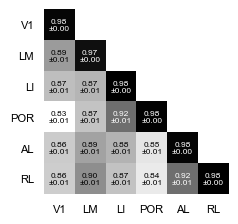

In [5]:
fig1 = plot_matrix(dcor, regions, figsize=(2.4,2.4))
if save: fig1[0].savefig(os.path.join(savepath, 'dcor_matrix.png'),bbox_inches='tight', dpi=600)

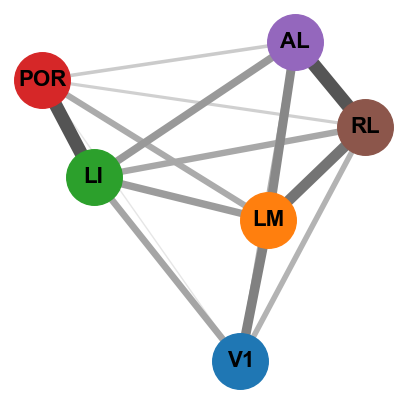

In [6]:
fig2 = make_graph(dcor, regions, seed=2, theta=150, mirror=False, figsize=(5,5))
if save: fig2[0].savefig(os.path.join(savepath, 'dcor_graph.pdf'),bbox_inches='tight')

## 2. Partial distance correlation

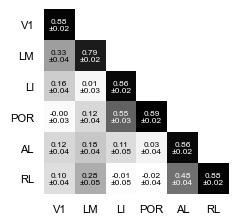

In [7]:
fig3 = plot_matrix(pdcor, regions, figsize=(2.4,2.4))
if save: fig3[0].savefig(os.path.join(savepath, 'pdcor_matrix.png'),bbox_inches='tight')

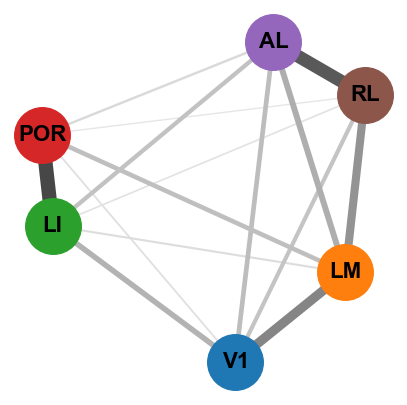

In [8]:
fig4 = make_graph(pdcor, regions, seed=0, theta=-90, mirror=False, figsize=(5,5))
if save: fig4[0].savefig(os.path.join(savepath, 'pdcor_graph.pdf'),bbox_inches='tight')

In [9]:
fig5 = plot_hubness(hubness[...,0]-hubness0[...,0])
fig5.show()
if save: fig5.write_html(os.path.join(savepath, 'hubness.html'))

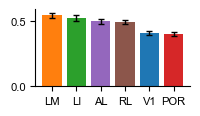

In [10]:
fig52 = plot_hubness_bar(hubness, figsize=(2,1))
if save: fig52[0].savefig(os.path.join(savepath, 'hubness_bar.pdf'),bbox_inches='tight')

## 3. Spatial mask size

In [18]:
# Plotting functions
def get_spatial_mask_size(spatial):
    '''Calculate the size of the spatial mask as the area of the Gaussian ellipse'''
    popts, r2 = spatial['popts'], spatial['r2']
    # popts are amplitude, xo, yo, sigma_x, sigma_y, theta, offset
    sx, sy = 2*np.abs(popts[:,3]), 2*np.abs(popts[:,4])
    area = sx*sy*np.pi

    mask = r2 > 0.8
    print(mask.sum()/mask.shape[0], mask.sum())
    return area[mask]

def plot_spatial_mask_size(data, regions, figsize=(6,5)):
    '''Plot spatial mask size over regions'''
    # Normalise to V1
    norm = np.median(data[0])
    data_norm = [d/norm for d in data]
    data_m = [np.median(d) for d in data_norm]
    data_s = [d.std()/np.sqrt(d.shape[0])*1.2533 for d in data_norm]
    
    fig, ax = pl.subplots(figsize=figsize)
    bp1 = ax.boxplot(data_norm, showfliers=False, positions=np.arange(1, len(regions)+1), widths=0.5, 
                     patch_artist=True, medianprops=dict(color='k'))

    for patch, color in zip(bp1['boxes'], colors):
        patch.set_facecolor(color)

    ax.set_xticklabels(regions)
    ax.set_ylabel("Spatial mask area (norm. to V1)")

    return fig, ax

def plot_spatial_mask_size_pie(data, regions, figsize=(6,5)):
    '''Plot spatial mask size over regions as pie chart'''
    # Normalise to V1
    norm = np.median(data[0])
    data_norm = [d/norm for d in data]
    data_m = np.array([np.median(d) for d in data_norm])
    data_s = np.array([[np.percentile(d, 25), np.percentile(d, 75)] for d in data_norm])

    fig, ax = pl.subplots(figsize=figsize, subplot_kw=dict(projection="polar"))
    # Plot a single pie chart per region
    ax.bar(np.arange(len(regions))/len(regions) * 2*np.pi, height=data_s[:,1]-data_s[:,0], bottom=data_s[:,0], width=np.pi*2/len(regions), color=colors, alpha=.75)
    ax.bar(np.arange(len(regions))/len(regions) * 2*np.pi, height=0.04, bottom=data_m-0.02, width=np.pi*2/len(regions), color=colors)
    ax.bar(np.arange(len(regions))/len(regions) * 2*np.pi, height=data_s[:,0], width=np.pi*2/len(regions), color=colors, alpha=0.5)

    ticks = [0, 0.5, 1, 1.5]
    for i in ticks:
        ax.plot(np.linspace(0,2*np.pi, 100), np.ones(100)*i, ls='--', color='k', zorder=99, alpha=0.25)
    ax.plot([0,0,0], [0, 1, 1.5], 'k-')
    ax.scatter(np.zeros(len(ticks)), ticks, color='k', marker='|', linewidths=2)
    ax.grid(False)
    ax.spines['polar'].set_visible(False)
    ax.set_ylim(0, 1.51)
    ax.set_xticks(np.arange(len(regions))/len(regions) * 2*np.pi)
    ax.set_xticklabels(regions)
    ax.set_yticks([])

    return fig, ax

def plot_dist2spatial(dist, spatial, regions, figsize=(6,5)):
    '''Plot distance from V1 vs spatial mask area'''
    dist_m = 1-np.mean(dist, axis=-1)[0]
    dist_m = dist_m-dist_m[0]
    dist_m[0] = 0
    dist_s = dist.std(axis=-1)[0]*1.2533

    norm = np.median(spatial[0])
    spatial_norm = [d/norm for d in spatial]
    spatial_m = [np.median(d) for d in spatial_norm]
    spatial_s = [d.std()/np.sqrt(d.shape[0])*1.2533 for d in spatial_norm]

    # Compute linregress
    x = np.concatenate([np.repeat(dist_m[i], spatial_norm[i].shape[0]) for i in range(len(dist))])
    model = HuberRegressor()
    model.fit(x.reshape(-1,1), np.concatenate(spatial_norm))
    print(model.score(x.reshape(-1,1), np.concatenate(spatial_norm)))
    p = np.polyfit(dist_m, spatial_m, deg=1)

    fig, ax = pl.subplots(figsize=figsize)
    for i, region in enumerate(regions):
        ax.errorbar(dist_m[i], spatial_m[i], xerr=dist_s[i], yerr=spatial_s[i], marker='o', ls='', capsize=2, color=colors[i], lw=1, ms=4)
    
    ax.plot(np.linspace(0,1,10), np.polyval([model.coef_[0], model.intercept_], np.linspace(0,1,10)), ls='--', color=[.5]*3)
    ax.set_xticks([0, 0.5, 1])
    # ax.set_xlabel('Distance from V1 (1-pdcor)')
    # ax.set_ylabel('Spatial mask area (norm. to V1)')

    # Inset
    axins = inset_axes(ax, width='80%', height='40%', bbox_to_anchor=(.125, .55, .3, .9), bbox_transform=(ax.transAxes), loc=3)
    bp1 = axins.boxplot(spatial_norm, showfliers=False, positions=np.arange(1, len(regions)+1), widths=0.5, 
                     patch_artist=True, medianprops=dict(color='k', linewidth=1), boxprops=dict(linewidth=1), whiskerprops=dict(linewidth=1),
                     capprops=dict(linewidth=1))

    for patch, color in zip(bp1['boxes'], colors):
        patch.set_facecolor(color)

    axins.set_xticklabels(['']*len(regions))
    axins.spines['top'].set_visible(False)
    axins.spines['right'].set_visible(False)
    axins.set_xticks([])

    return fig, ax
    

In [19]:
# Filepath to data
fp_spatial = r'D:\Data\DeepMouse\Results\representational_similarity'
spatial_masks = [np.load(os.path.join(fp_spatial, f"spatial_mask_fit_{region}.npy"), allow_pickle=True).item() for region in regions]
area = [get_spatial_mask_size(spatial) for spatial in spatial_masks]
radius = [np.sqrt(a/np.pi) for a in area]

0.6777150916784203 961
0.5459496255956433 802
0.4766187050359712 530
0.5121495327102804 548
0.4699537750385208 610
0.4794215795328142 431


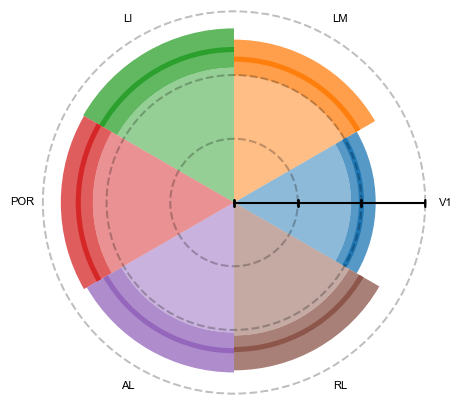

In [20]:
fig6 = plot_spatial_mask_size_pie(radius, regions, figsize=(5,5))
if save: fig6[0].savefig(os.path.join(savepath, 'spatial_mask_radius.pdf'),bbox_inches='tight')

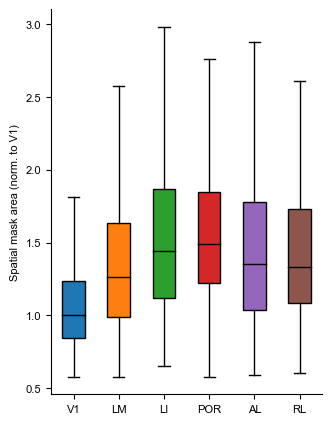

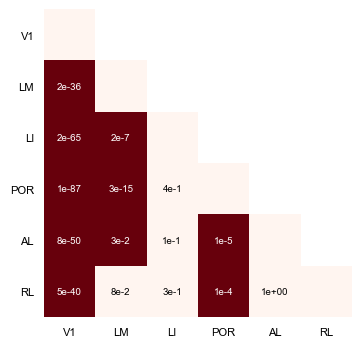

In [21]:
fig7 = plot_spatial_mask_size(area, regions, figsize=(3.5,5))
if save: fig7[0].savefig(os.path.join(savepath, 'spatial_mask_area.pdf'),bbox_inches='tight')
stats = posthoc_dunn(area, p_adjust='bonferroni') 
fig7_stats = plot_stats(np.array(stats), regions, figsize=(4,4))
if save: fig7_stats.savefig(os.path.join(savepath, 'spatial_mask_area_stats.pdf'),bbox_inches='tight')

0.04653080197820203


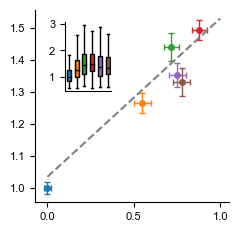

In [22]:
fig8 = plot_dist2spatial(pdcor, area, regions, figsize=(2.5,2.5))
if save: fig8[0].savefig(os.path.join(savepath, 'spatial_mask_distance.eps'),bbox_inches='tight')

## 4. Predictability

In [23]:
# Plotting functions
def plot_matrix_full(data, regions, figsize=(6,5)):
    '''Given distance correlation data (region, region, nrepeat), plot as matrix'''
    data_m = data.mean(axis=-1)
    data_s = data.std(axis=-1)
    mask = np.tri(data_m.shape[0], k=-1).T
    data_diff = (data_m-data_m.min())/(data_m.max()-data_m.min())

    fig, ax = pl.subplots(figsize=figsize)
    ax.imshow(data_m, cmap='Reds', vmin=data_m.min(), vmax=data_m.max())
    for i in range(len(regions)):
        for j in range(len(regions)):
            if data_diff[i,j] < 0.5: color = [0]*3
            else: color = [1] * 3
            ax.text(j,i, f"{data_m[i,j]:.3f}\n±{data_s[i,j]:.3f}", ha='center', va='center', size=6, color=color)
    ax.set_xticks(range(data.shape[0]))
    ax.set_xticklabels(regions)
    ax.set_yticks(range(data.shape[0]))
    ax.set_yticklabels(regions)
    ax.invert_yaxis()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')

    ax.set_xlabel("Target")
    ax.set_ylabel("Source")

    return fig, ax

def plot_predictability(data, regions, figsize=(6,5)):
    '''Plot predictability defined as the average across sources'''
    predictability = data.mean(axis=-1).mean(axis=0)
    sem = data.std(axis=-1)/np.sqrt(data.shape[-1])
    sem = np.sqrt((sem**2).sum(axis=0))

    fig, ax = pl.subplots(figsize=figsize)
    ax.errorbar(np.arange(len(regions)), predictability, yerr=sem, marker='o', ls='', capsize=5, color='k')
    ax.set_xticks(np.arange(len(regions)))
    ax.set_xticklabels(regions)
    ax.set_ylabel("Mean predictability (r2)")

    return fig, ax

In [24]:
fp_predict = r'D:\Data\DeepMouse\Results\representational_similarity\linear_predicatbility_pls_cv-5.npy'
fp_predict0 = r'D:\Data\DeepMouse\Results\representational_similarity\linear_predicatbility_pls0_cv-5.npy'

pls_predict = np.load(fp_predict)
pls_predict0 = np.load(fp_predict0)

FileNotFoundError: [Errno 2] No such file or directory: 'D:\\Data\\DeepMouse\\Results\\representational_similarity\\linear_predicatbility_pls_cv-5.npy'

In [ ]:
fig9 = plot_matrix_full(pls_predict, regions)
if save: fig9[0].savefig(os.path.join(savepath, 'linear_predictability_matrix.pdf'))

NameError: name 'pls_predict' is not defined

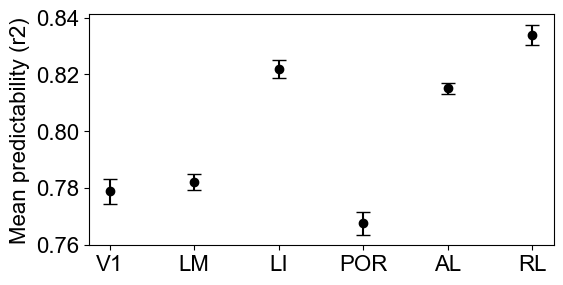

In [ ]:
fig10 = plot_predictability(pls_predict, regions, figsize=(6,3))
if save: fig10[0].savefig(os.path.join(savepath, 'linear_predictability.pdf'))